In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [27]:
# Load the dataset
mcdonalds = pd.read_csv('https://homepage.boku.ac.at/leisch/MSA/datasets/mcdonalds.csv')

# Display column names
print(mcdonalds.columns)


Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')


In [28]:
#shows the dimensions of the dataset
mcdonalds.shape

(1453, 15)

In [29]:
#shows the first 5 rows of the dataset
mcdonalds.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,+4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,+2,49,Once a month,Male


In [30]:
# Extract columns 1 to 11 and convert "Yes" to 1 and "No" to 0
MD_x = mcdonalds.iloc[:, 0:11].apply(lambda x: (x == "Yes").astype(int))

# Calculate column means
col_means = MD_x.mean()
print(round(col_means, 2))

yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64


In [31]:
# Perform PCA
MD_pca = PCA()
MD_pca.fit(MD_x)

# Print summary
print("PCA Summary:")
print("Standard deviation", MD_pca.explained_variance_)
print("Proportion of variance ", MD_pca.explained_variance_ratio_)
print("Cumulative proportion of variance ", MD_pca.explained_variance_ratio_.cumsum())
# Print PCA with specified number of digits
np.set_printoptions(precision=1)
print(MD_pca)

PCA Summary:
Standard deviation [0.6 0.4 0.3 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Proportion of variance  [0.3 0.2 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0. ]
Cumulative proportion of variance  [0.3 0.5 0.6 0.7 0.8 0.8 0.9 0.9 0.9 1.  1. ]
PCA()


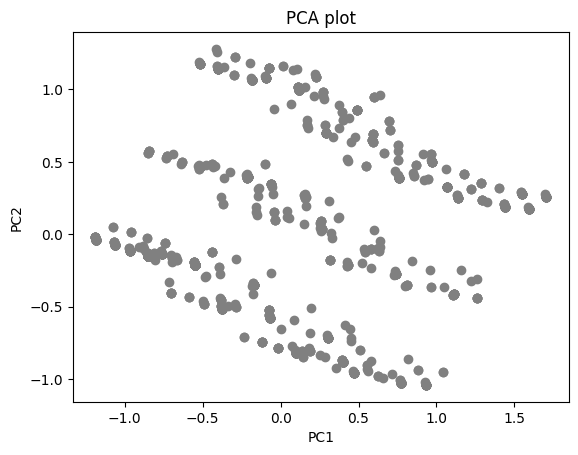

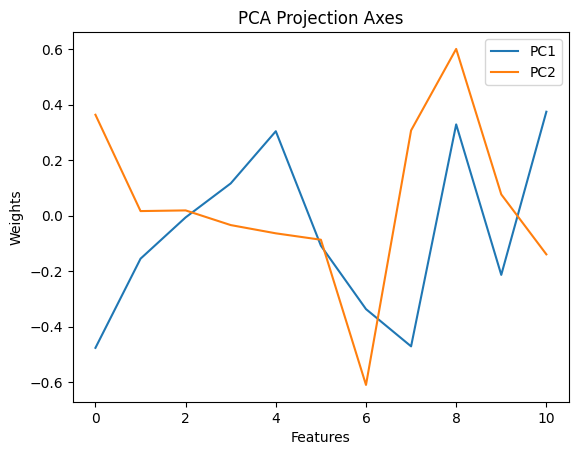

In [32]:
# Plot PCA
pca_scores = MD_pca.transform(MD_x)
plt.scatter(pca_scores[:, 0], pca_scores[:, 1], c='grey')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA plot')
plt.show()

# Plot PCA axes
plt.figure()
plt.plot(MD_pca.components_[0], label='PC1')
plt.plot(MD_pca.components_[1], label='PC2')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.title('PCA Projection Axes')
plt.legend()
plt.show()


In [33]:
from sklearn.cluster import KMeans

In [42]:
# Perform K-means clustering
np.random.seed(1234)
inertia_values = []
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
    kmeans.fit(MD_x)
    inertia_values.append(kmeans.inertia_)

# Relabel clusters
best_k = inertia_values.index(min(inertia_values)) + 2
kmeans_best = KMeans(n_clusters=best_k, n_init=10, random_state=1234)
MD_kmeans = kmeans_best.fit_predict(MD_x)
MD_kmeans += 1

print("Cluster labels:")
print(MD_kmeans)


Cluster labels:
[5 3 6 ... 6 4 1]


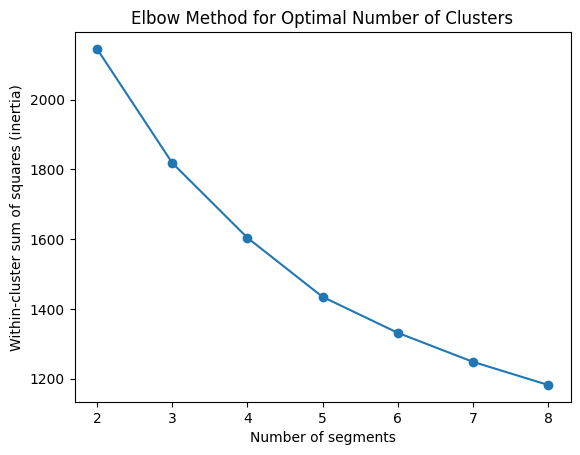

In [36]:
# Plot the elbow curve
plt.plot(range(2, 9), inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of segments')
plt.ylabel('Within-cluster sum of squares (inertia)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

in R they use bootFlexclust function, Since there's no direct equivalent of the bootFlexclust function in the flexclust library for python. We can implement bootstrapping for clustering manually using the numpy library

In [37]:
# Define bootstrap function
def bootstrap_clustering(data, k_range, n_rep, n_boot):
    bootstrap_results = []
    for _ in range(n_boot):
        sample_indices = np.random.choice(data.shape[0], size=data.shape[0], replace=True)
        bootstrap_data = data.iloc[sample_indices]
        inertia_values = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
            kmeans.fit(bootstrap_data)
            inertia_values.append(kmeans.inertia_)
        bootstrap_results.append(inertia_values)
    return np.array(bootstrap_results)

# Perform bootstrapping
MD_boot_results = bootstrap_clustering(MD_x, range(2, 9), n_rep=10, n_boot=100)

# Display bootstrap results
print("Bootstrap results shape:", MD_boot_results.shape)

Bootstrap results shape: (100, 7)


In [38]:
from sklearn.metrics import adjusted_rand_score

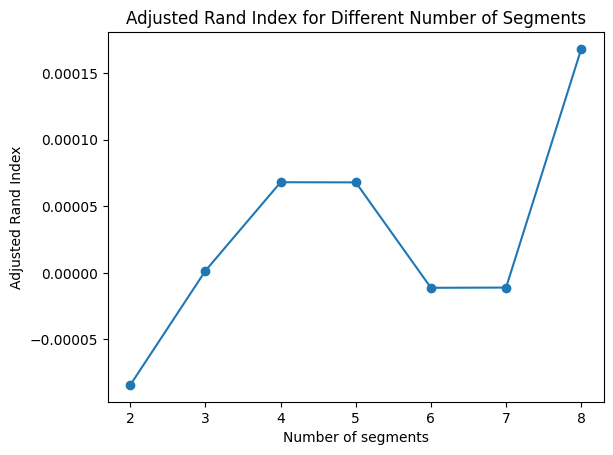

In [39]:
# Define function to compute adjusted Rand index for K-means clustering
def compute_adjusted_rand_index(data, k_range, n_rep, n_boot):
    adjusted_rand_indices = []
    for k in k_range:
        rand_indices = []
        for _ in range(n_boot):
            sample_indices = np.random.choice(data.shape[0], size=data.shape[0], replace=True)
            bootstrap_data = data.iloc[sample_indices]
            kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
            cluster_labels = kmeans.fit_predict(bootstrap_data)
            true_labels = np.random.choice(range(k), size=len(cluster_labels))
            rand_index = adjusted_rand_score(true_labels, cluster_labels)
            rand_indices.append(rand_index)
        avg_rand_index = np.mean(rand_indices)
        adjusted_rand_indices.append(avg_rand_index)
    return adjusted_rand_indices

# Compute adjusted Rand index for each number of segments
k_range = range(2, 9)
adjusted_rand_indices = compute_adjusted_rand_index(MD_x, k_range, n_rep=10, n_boot=100)

# Plot adjusted Rand index versus number of segments
plt.plot(k_range, adjusted_rand_indices, marker='o', linestyle='-')
plt.xlabel('Number of segments')
plt.ylabel('Adjusted Rand Index')
plt.title('Adjusted Rand Index for Different Number of Segments')
plt.show()

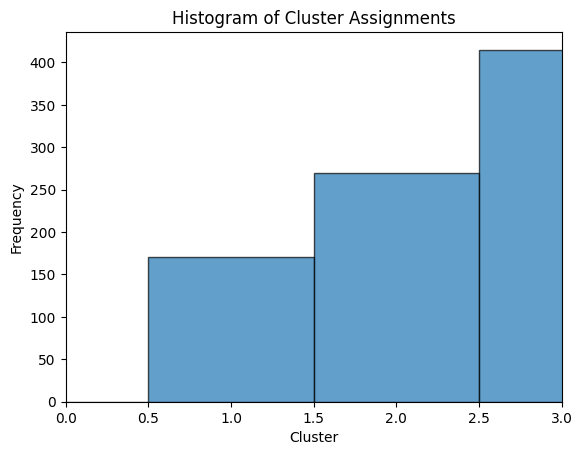

In [40]:
# Plot histogram of cluster assignments
plt.hist(MD_kmeans, bins=range(5), align='left', edgecolor='black', alpha=0.7)
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.xlim(0, 3)
plt.title('Histogram of Cluster Assignments')
plt.show()

In [44]:
# Extract cluster assignments for the specific number of segments (4 in this case)
MD_k4 = MD_kmeans

print("Cluster assignments for k=4:")
print(MD_k4)

Cluster assignments for k=4:
[5 3 6 ... 6 4 1]


In Python, there isn't a direct equivalent function like slswFlexclust from the flexclust package in R. However, you can use various methods to interpret and analyze the clusters obtained from K-means clustering. One common approach is to analyze the characteristics of each cluster by examining the mean values of features within each cluster.


In [45]:
# Group the data by cluster and calculate mean values for each feature
cluster_means = pd.DataFrame(MD_x)
cluster_means['Cluster'] = MD_kmeans
cluster_means = cluster_means.groupby('Cluster').mean()

# Display the mean values for each cluster
print("Mean values for each feature within each cluster:")
print(cluster_means)

Mean values for each feature within each cluster:
            yummy  convenient     spicy  fattening    greasy      fast  \
Cluster                                                                  
1        0.017544    0.590643  0.076023   0.964912  0.865497  0.713450   
2        0.851852    0.985185  0.085185   1.000000  0.000000  0.970370   
3        0.837370    0.982699  0.121107   0.986159  1.000000  0.948097   
4        0.880952    0.952381  0.119048   0.000000  0.023810  0.952381   
5        0.000000    0.942029  0.057971   0.920290  0.543478  0.971014   
6        0.926606    0.958716  0.091743   0.958716  0.614679  0.853211   
7        0.021739    0.833333  0.079710   0.963768  0.804348  0.949275   
8        0.116505    0.912621  0.106796   0.689320  0.048544  0.766990   

            cheap     tasty  expensive   healthy  disgusting  
Cluster                                                       
1        0.035088  0.064327   0.970760  0.040936    0.847953  
2        0.918519  0

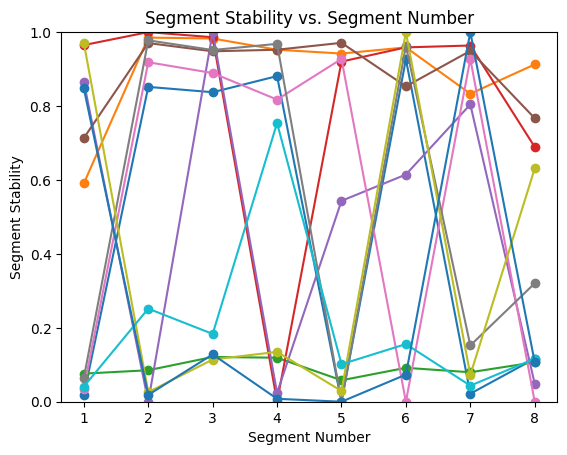

In [63]:
# Assuming you have segment stability values stored in a list or array
segment_numbers = range(1, len(cluster_means) + 1)
segment_stability_values = cluster_means

# Plot segment stability
plt.plot(segment_numbers, segment_stability_values, marker='o', linestyle='-')
plt.xlabel('Segment Number')
plt.ylabel('Segment Stability')
plt.title('Segment Stability vs. Segment Number')
plt.ylim(0, 1)
plt.show()

For fitting finite mixture models in Python, you can use libraries such as scikit-learn or statsmodels. However, stepwise fitting of finite mixture models similar to stepFlexmix in R might not have a direct equivalent in these libraries.




In [66]:
from sklearn.mixture import GaussianMixture

In [67]:
# Fit Gaussian Mixture Model
gmm_models = []
for n_components in range(2, 9):
    gmm = GaussianMixture(n_components=n_components, n_init=10, random_state=1234)
    gmm.fit(MD_x)
    gmm_models.append(gmm)

# Display fitted models
for i, gmm in enumerate(gmm_models):
    print(f"Number of components: {i + 2}")
    print(gmm)
    print()

Number of components: 2
GaussianMixture(n_components=2, n_init=10, random_state=1234)

Number of components: 3
GaussianMixture(n_components=3, n_init=10, random_state=1234)

Number of components: 4
GaussianMixture(n_components=4, n_init=10, random_state=1234)

Number of components: 5
GaussianMixture(n_components=5, n_init=10, random_state=1234)

Number of components: 6
GaussianMixture(n_components=6, n_init=10, random_state=1234)

Number of components: 7
GaussianMixture(n_components=7, n_init=10, random_state=1234)

Number of components: 8
GaussianMixture(n_components=8, n_init=10, random_state=1234)



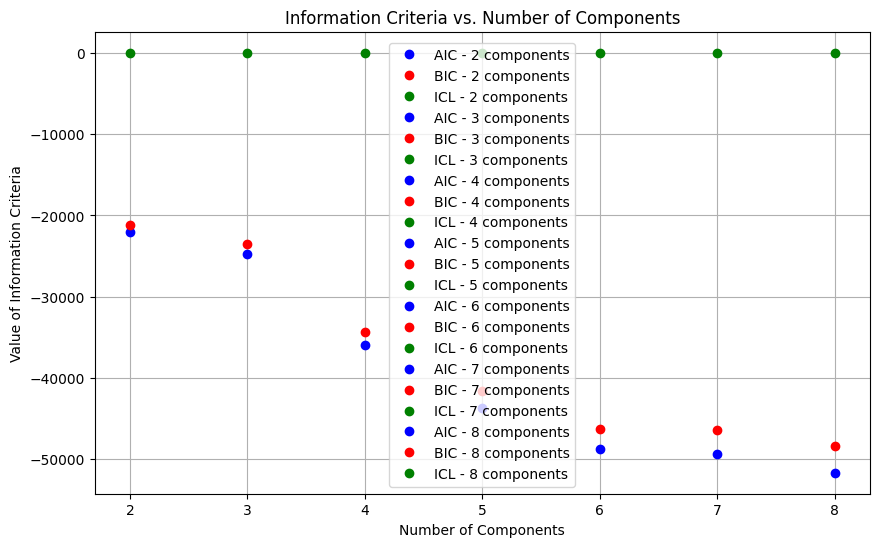

In [72]:
# Fit Gaussian Mixture Models for a range of components
models = {}
for n_components in range(2, 9):
    gmm = GaussianMixture(n_components=n_components, n_init=10, random_state=1234)
    gmm.fit(MD_x)
    models[n_components] = gmm

# Plot AIC, BIC, and ICL
plt.figure(figsize=(10, 6))
for n_components, model in models.items():
    plt.plot(n_components, model.aic(MD_x), 'bo', label=f'AIC - {n_components} components')
    plt.plot(n_components, model.bic(MD_x), 'ro', label=f'BIC - {n_components} components')
    plt.plot(n_components, model.lower_bound_, 'go', label=f'ICL - {n_components} components')

plt.xlabel('Number of Components')
plt.ylabel('Value of Information Criteria')
plt.title('Information Criteria vs. Number of Components')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
# Fit Gaussian Mixture Model with the desired number of components (e.g., 4)
gmm_model_4 = GaussianMixture(n_components=4, n_init=10, random_state=1234)
gmm_model_4.fit(MD_x)

# Obtain cluster assignments from the mixture model
MD_m4_clusters = gmm_model_4.predict(MD_x)

# Compare cluster assignments between K-means and the selected mixture model
cluster_comparison = pd.DataFrame({'kmeans': MD_k4, 'mixture': MD_m4_clusters})

# Display the comparison
print("Comparison of cluster assignments:")
print(cluster_comparison)

Comparison of cluster assignments:
      kmeans  mixture
0          5        3
1          3        3
2          6        2
3          3        0
4          5        0
...      ...      ...
1448       1        3
1449       2        2
1450       6        3
1451       4        0
1452       1        3

[1453 rows x 2 columns]


In [77]:
# Initialize Gaussian Mixture Models with the cluster assignments
gmm_model_4a = GaussianMixture(n_components=4, n_init=10, random_state=1234)
gmm_model_4 = GaussianMixture(n_components=4, n_init=10, random_state=1234)

# Fit the models
gmm_model_4a.fit(MD_x)
gmm_model_4.fit(MD_x)

# Compute the log-likelihoods
log_likelihood_4a = gmm_model_4a.score(MD_x)
log_likelihood_4 = gmm_model_4.score(MD_x)

# Calculate degrees of freedom
num_samples, num_features = MD_x.shape
df = num_samples * num_features

# Print the results
print("Log Likelihood for MD_m4a:", log_likelihood_4a)
print("Log Likelihood for MD_m4:", log_likelihood_4)
print("Degrees of Freedom:", df)

Log Likelihood for MD_m4a: 12.580946387710531
Log Likelihood for MD_m4: 12.580946387710531
Degrees of Freedom: 15983


In [78]:
like_counts = mcdonalds['Like'].value_counts().sort_index(ascending=False)

# Print the counts in reverse order
print(like_counts)

Like
I love it!+5    143
I hate it!-5    152
0               169
-4               71
-3               73
-2               59
-1               58
+4              160
+3              229
+2              187
+1              152
Name: count, dtype: int64


In [81]:
# Filter out non-numeric values and convert to numeric
mcdonalds['Like_n'] = mcdonalds['Like'].apply(lambda x: 6 - int(x) if x.isdigit() else None)

# Count the occurrences of each unique value in the 'Like_n' column
like_n_counts = mcdonalds['Like_n'].value_counts()

# Print the counts
print(like_n_counts)

Like_n
6.0    169
Name: count, dtype: int64


In [83]:
columns = mcdonalds.columns[0:11]  # Assuming the first 11 columns are the ones you want to include
f = 'Like_n ~ ' + ' + '.join(columns)

# Print the formula
print(f)

Like_n ~ yummy + convenient + spicy + fattening + greasy + fast + cheap + tasty + expensive + healthy + disgusting


In [96]:
# Refit the models
refitted_results = [result.model.refit() for result in results]

# Display the summary of the refitted models
for i, result in enumerate(refitted_results):
    print(f"Cluster {i+1}:\n{result.summary()}\n")


In [102]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

<ipython-input-103-1565397c9ff3>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(square_distance_matrix, method='single')


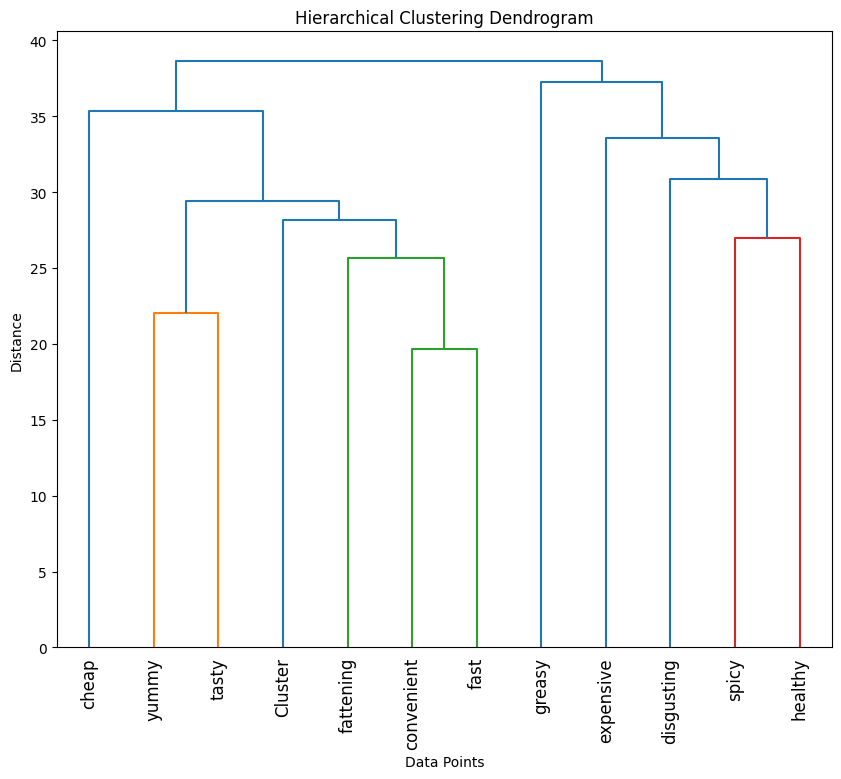

In [103]:
# Compute the pairwise distance matrix
distance_matrix = pdist(MD_x.T)

# Convert the pairwise distance matrix to a square distance matrix
square_distance_matrix = squareform(distance_matrix)

# Perform hierarchical clustering
linkage_matrix = linkage(square_distance_matrix, method='single')

# Plot the dendrogram
plt.figure(figsize=(10, 8))
dendrogram(linkage_matrix, labels=MD_x.columns, orientation='top', leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()


In [115]:
import seaborn as sns


<ipython-input-116-e0629137eac1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x='Like', col='Cluster', data=data, kind='count', palette='Blues')


<Figure size 1000x600 with 0 Axes>

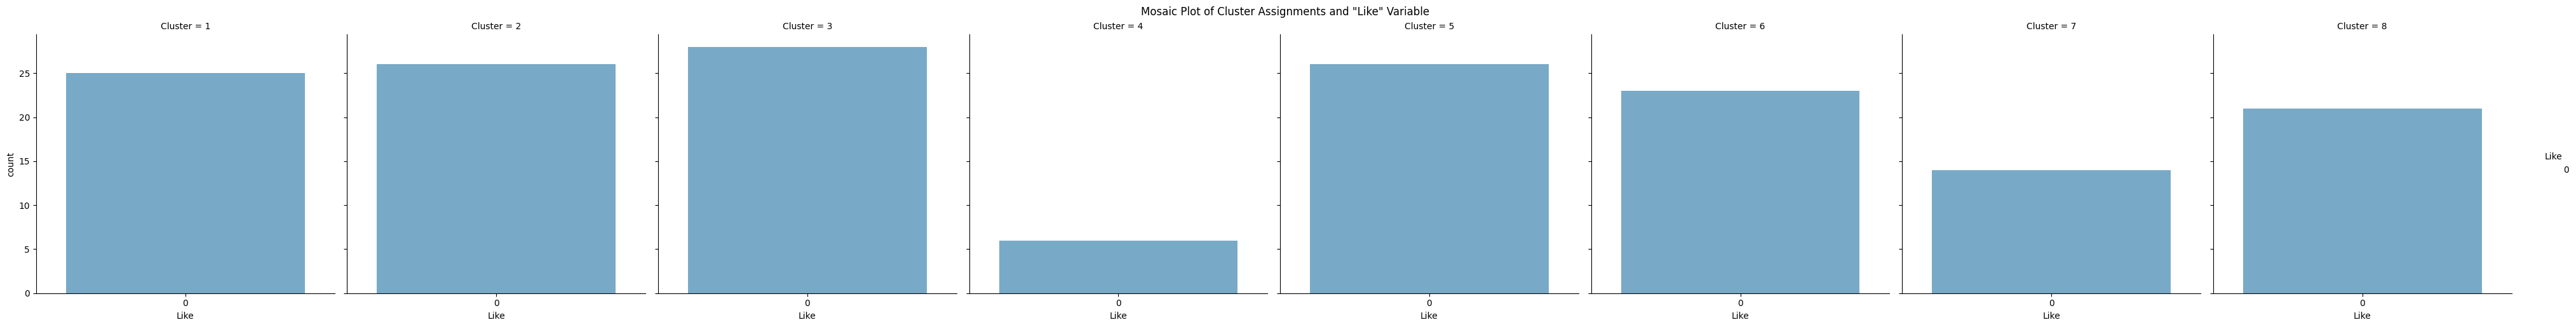

In [116]:
# Convert cluster assignments to a pandas Series
cluster_series = pd.Series(MD_k4, name='Cluster')

# Combine cluster assignments with 'Like' variable
data = pd.concat([cluster_series, mcdonalds['Like']], axis=1)

# Plot the mosaic plot using seaborn
plt.figure(figsize=(10, 6))
sns.catplot(x='Like', col='Cluster', data=data, kind='count', palette='Blues')
plt.suptitle('Mosaic Plot of Cluster Assignments and "Like" Variable', y=1.02)
plt.show()

<Figure size 1000x600 with 0 Axes>

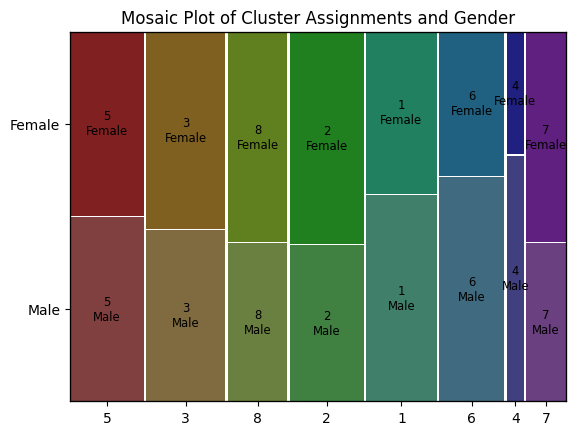

In [118]:
# Combine cluster assignments with 'Gender' variable
data = pd.concat([pd.Series(k4, name='Cluster'), mcdonalds['Gender']], axis=1)

# Plot the mosaic plot
plt.figure(figsize=(10, 6))
mosaic(data, ['Cluster', 'Gender'], title='Mosaic Plot of Cluster Assignments and Gender')
plt.show()

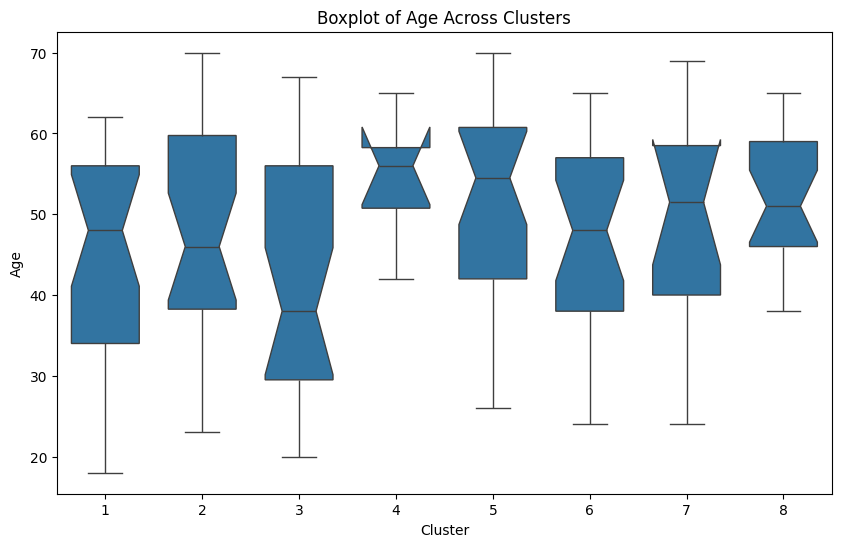

In [120]:
# Combine cluster assignments with 'Age' variable
data = pd.concat([pd.Series(k4, name='Cluster'), mcdonalds['Age']], axis=1)

# Plot the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Age', data=data, width=0.7, notch=True)
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.title('Boxplot of Age Across Clusters')
plt.show()

In [121]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder
import graphviz

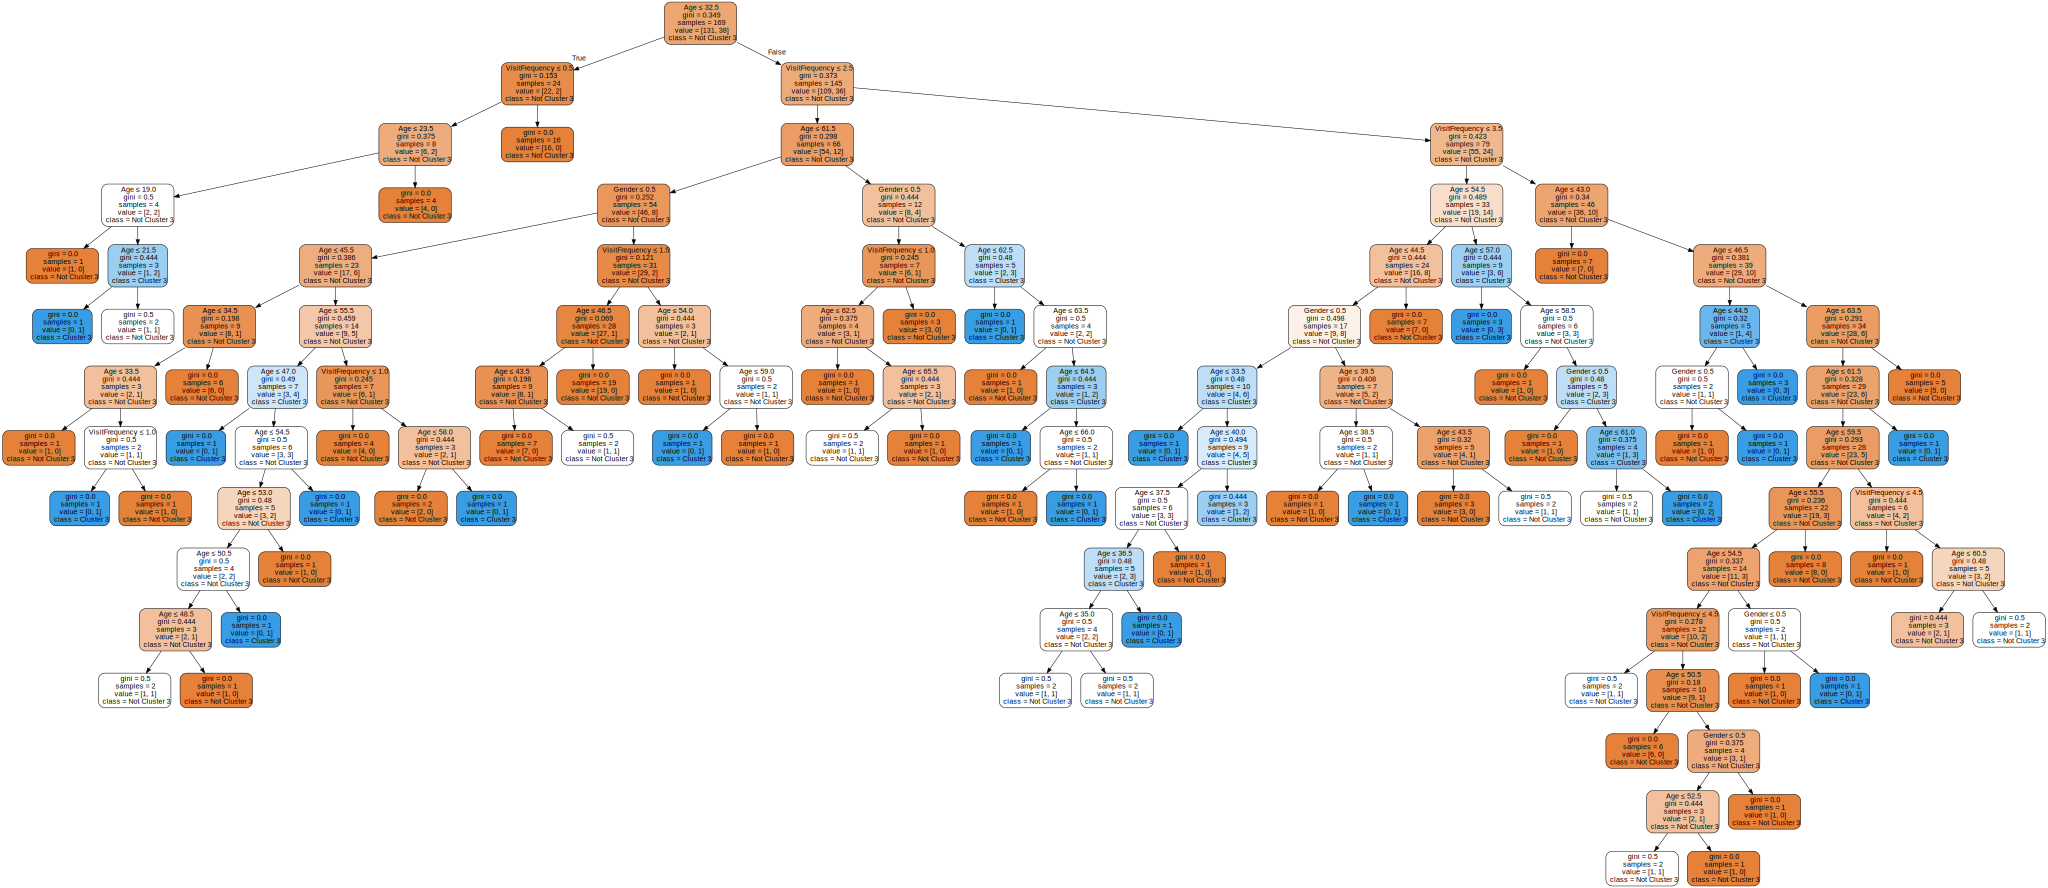

In [124]:
# Encode 'Like' variable
label_encoder = LabelEncoder()
mcdonalds['Like_n'] = label_encoder.fit_transform(mcdonalds['Like'])

# Encode categorical variables
mcdonalds['VisitFrequency'] = label_encoder.fit_transform(mcdonalds['VisitFrequency'])
mcdonalds['Gender'] = label_encoder.fit_transform(mcdonalds['Gender'])

# Prepare features and target variable
X = mcdonalds[['Like_n', 'Age', 'VisitFrequency', 'Gender']]
y = (k4 == 3)[:len(X)].astype(int)  # Ensure 'y' has the same length as 'X'

# Fit decision tree classifier
tree = DecisionTreeClassifier()
tree.fit(X, y)

# Export the decision tree to Graphviz format
dot_data = export_graphviz(tree, out_file=None, feature_names=X.columns, class_names=['Not Cluster 3', 'Cluster 3'],
                           filled=True, rounded=True, special_characters=True)

# Visualize the decision tree
graph = graphviz.Source(dot_data)
graph.render('decision_tree')  # Optional: save the tree as PDF or PNG
graph

In [133]:
# Ensure the length of 'k4' matches the number of rows in the DataFrame
k4 = k4[:len(mcdonalds)]

# Calculate the mean of 'VisitFrequency' for each cluster
visit = mcdonalds.groupby(k4)['VisitFrequency'].mean()

# Print the result
print(visit)

1    2.235294
2    2.200000
3    2.473684
4    2.133333
5    1.923077
6    2.423077
7    3.615385
8    1.750000
Name: VisitFrequency, dtype: float64
